<a href="https://colab.research.google.com/github/puja431996/Notebook/blob/master/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Mount Google Drive

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls

drive  sample_data


###UnZip Dataset

---



In [3]:
!cd drive && cd 'My Drive' && cd COVID_19 && cd xray_augmented_mendley && ls

Dataset_All_Augmented.zip


In [4]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/COVID_19/xray_augmented_mendley/Dataset_All_Augmented.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
Dataset All Augmented/                         2020-03-26 09:56:58            0
Dataset All Augmented/COVID-19/                2020-03-26 12:01:12            0
Dataset All Augmented/COVID-19/COVID-19 (1).jpeg 2020-03-26 12:00:24        60413
Dataset All Augmented/COVID-19/COVID-19 (1).jpg 2020-03-26 11:59:26        37991
Dataset All Augmented/COVID-19/COVID-19 (1).png 2020-03-26 11:59:36       319354
Dataset All Augmented/COVID-19/COVID-19 (10).jpeg 2020-03-26 12:00:14        57880
Dataset All Augmented/COVID-19/COVID-19 (10).jpg 2020-03-26 11:59:52        37923
Dataset All Augmented/COVID-19/COVID-19 (100).jpg 2020-03-26 12:00:18        41188
Dataset All Augmented/COVID-19/COVID-19 (101).jpg 2020-03-26 12:00:18        41749
Dataset All Augmented/COVID-19/COVID-19 (102).jpg 2020-03-26 12:00:20        41693
Dataset All Augmented/COVID-19/COVID-19 (103).jpg 2020-03-26 12:00:20        41366
Dataset All Augment

###Image Preprocessing 

---



In [94]:
import keras
from keras.preprocessing.image import ImageDataGenerator

img_height = 224
img_width = 224
batch_size = 32

train_data_dir = "Dataset All Augmented/"
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary',
    subset='validation',
    shuffle=False) # set as validation data

Found 1460 images belonging to 2 classes.
Found 364 images belonging to 2 classes.


#COVID,NON-COVID DATASET

##TRAINING

In [0]:
import tensorflow as tf

###Pretrained Model MobileNetV2

---



In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [0]:
base_model.trainable = False


In [98]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)


###Custom Model

---



In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

###Compile Model

---



In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

###Early Stopping and CSV Log

---



In [0]:
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping
csv_logger = CSVLogger('COVID-19(MobileNetv2).csv', append=False, separator=';')
ES = EarlyStopping(monitor='val_accuracy', patience=3)

In [103]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


###Fit Model

---



In [104]:
history = model.fit(train_generator,steps_per_epoch=1460//32+1,epochs = 30,validation_data=validation_generator,validation_steps=364, callbacks=[csv_logger , ES] )

Epoch 1/30
46/46 [==============================] - 14s 304ms/step - loss: 0.7294 - accuracy: 0.5158 - val_loss: 0.7277 - val_accuracy: 0.4918
Epoch 2/30
46/46 [==============================] - 13s 287ms/step - loss: 0.6006 - accuracy: 0.6486 - val_loss: 0.6257 - val_accuracy: 0.6374
Epoch 3/30
46/46 [==============================] - 13s 278ms/step - loss: 0.5000 - accuracy: 0.7493 - val_loss: 0.5431 - val_accuracy: 0.7060
Epoch 4/30
46/46 [==============================] - 13s 279ms/step - loss: 0.4201 - accuracy: 0.8199 - val_loss: 0.4762 - val_accuracy: 0.7418
Epoch 5/30
46/46 [==============================] - 13s 273ms/step - loss: 0.3590 - accuracy: 0.8733 - val_loss: 0.4240 - val_accuracy: 0.7857
Epoch 6/30
46/46 [==============================] - 13s 277ms/step - loss: 0.3131 - accuracy: 0.8993 - val_loss: 0.3836 - val_accuracy: 0.7967
Epoch 7/30
46/46 [==============================] - 13s 276ms/step - loss: 0.2753 - accuracy: 0.9096 - val_loss: 0.3465 - val_accuracy: 0.8434

###Plot Acc and Loss

---



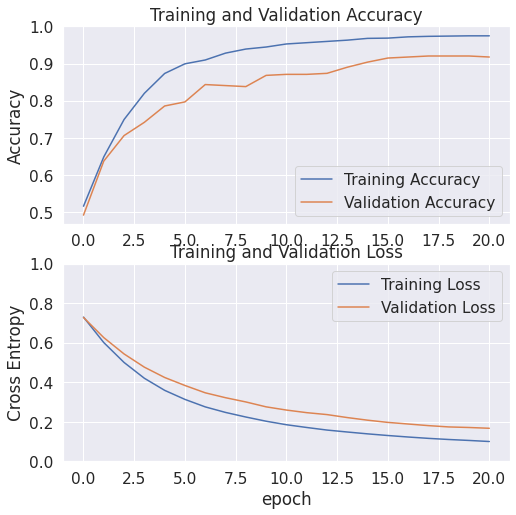

In [105]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

###Confusion Matrix

---



In [106]:
validation_generator.batch_index

21

In [0]:
validation_generator.reset()

In [108]:
validation_generator.batch_index

0

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
validation_generator.reset()
y_preds = model.predict_generator(generator=validation_generator, steps = 364)

In [111]:
validation_generator.class_indices

{'COVID-19': 0, 'Non-COVID-19': 1}

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
y_preds = y_preds>0

In [0]:
validation_generator.reset()
y_true = validation_generator.classes


In [115]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [0]:
mat = confusion_matrix(y_true, y_preds)

In [117]:
mat

array([[179,   3],
       [ 20, 162]])

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
 

    
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

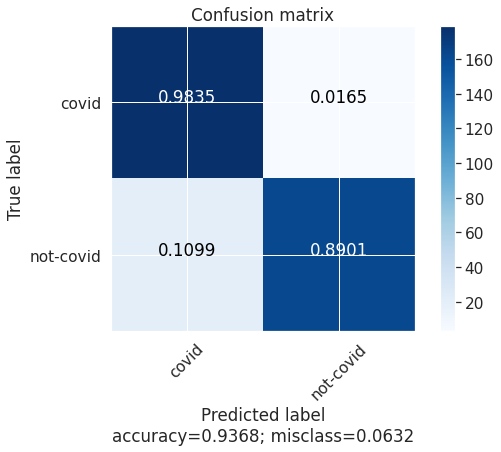

In [119]:
plot_confusion_matrix(mat,['covid','not-covid'])

In [0]:
from sklearn.metrics import classification_report

In [121]:
print('Classification Report')
target_names = ['covid','not-covid']
clf_report1 = classification_report(validation_generator.classes, y_preds, target_names=target_names)
print(classification_report(validation_generator.classes, y_preds, target_names=target_names))
print("Matrix :\n")
print(mat)

Classification Report
              precision    recall  f1-score   support

       covid       0.90      0.98      0.94       182
   not-covid       0.98      0.89      0.93       182

    accuracy                           0.94       364
   macro avg       0.94      0.94      0.94       364
weighted avg       0.94      0.94      0.94       364

Matrix :

[[179   3]
 [ 20 162]]


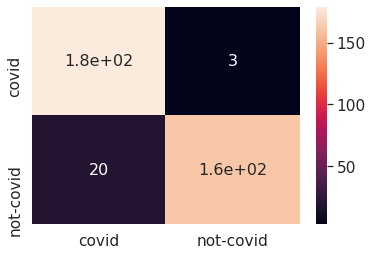

In [122]:
import pandas as pd
import seaborn as sns
df_cm = pd.DataFrame(mat, target_names, target_names)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

###Save Model

---



In [0]:
model.save("drive/My Drive/saved_models/mobilenetv2.h5")

##FINE-TUNING

In [0]:
base_model.trainable = True

In [125]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [127]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [128]:
len(model.trainable_variables)

58

In [0]:
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping
csv_logger1 = CSVLogger('COVID-19(MobileNetv2).csv', append=True, separator=';')
#ES1 = EarlyStopping(monitor='val_accuracy', baseline=1.0 ,patience=0)

In [130]:
fine_tune_epochs = 10
initial_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_generator,steps_per_epoch=1460//32+1,epochs = total_epochs,initial_epoch =  history.epoch[-1],validation_data=validation_generator,validation_steps=364,callbacks=[csv_logger1])

Epoch 21/40
46/46 [==============================] - 14s 297ms/step - loss: 0.1463 - accuracy: 0.9445 - val_loss: 0.1442 - val_accuracy: 0.9231
Epoch 22/40
46/46 [==============================] - 13s 282ms/step - loss: 0.0649 - accuracy: 0.9849 - val_loss: 0.1332 - val_accuracy: 0.9231
Epoch 23/40
46/46 [==============================] - 13s 279ms/step - loss: 0.0310 - accuracy: 0.9966 - val_loss: 0.1133 - val_accuracy: 0.9313
Epoch 24/40
46/46 [==============================] - 13s 275ms/step - loss: 0.0238 - accuracy: 0.9952 - val_loss: 0.0755 - val_accuracy: 0.9560
Epoch 25/40
46/46 [==============================] - 13s 280ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9615
Epoch 26/40
46/46 [==============================] - 13s 284ms/step - loss: 0.0081 - accuracy: 0.9993 - val_loss: 0.0442 - val_accuracy: 0.9670
Epoch 27/40
46/46 [==============================] - 13s 279ms/step - loss: 0.0066 - accuracy: 0.9993 - val_loss: 0.0308 - val_accuracy:

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

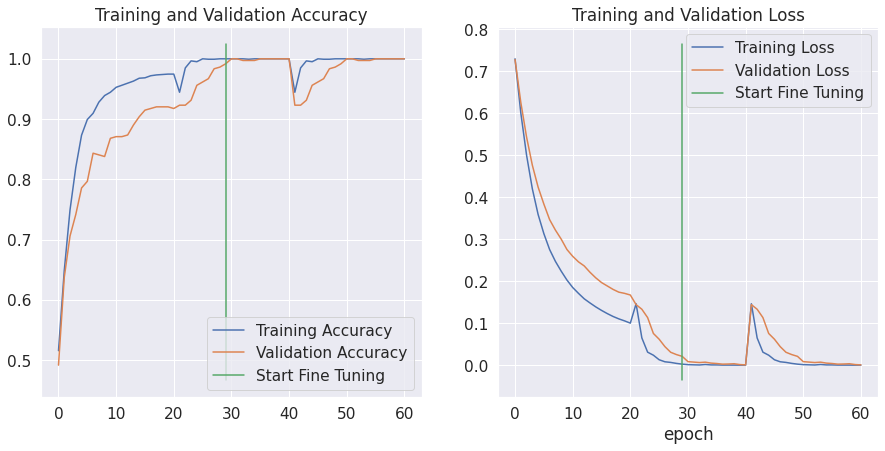

In [133]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
validation_generator.reset()
y_preds = model.predict_generator(generator=validation_generator, steps = 364)

In [0]:
y_preds = y_preds>0

In [0]:
validation_generator.reset()
y_true = validation_generator.classes

In [137]:
mat = confusion_matrix(y_true, y_preds)
mat

array([[182,   0],
       [  0, 182]])

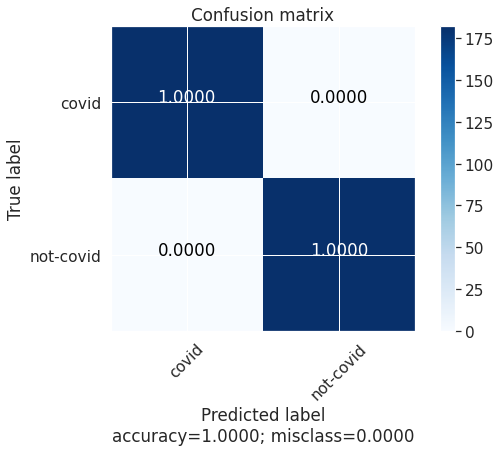

In [138]:
plot_confusion_matrix(mat,['covid','not-covid'])

In [0]:
clf_report = classification_report(y_true,y_preds,target_names = ['Covid','Not-Covid'],output_dict=True)

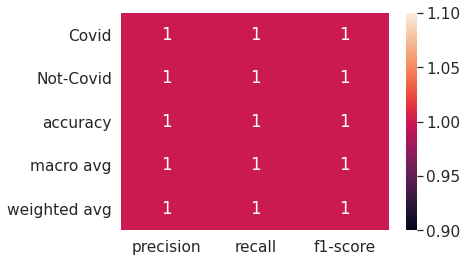

In [140]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [0]:
model.save("drive/My Drive/saved_models/mobilenetv2_finetuned.h5")

##TESTING

In [0]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [0]:
test_images_path = "/content/drive/My Drive/COVID_19/covid-chest-xray/images/"


In [0]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [0]:
test_image_arrays = []
for image in os.listdir(test_images_path):
  try:
    im = load_img(
      os.path.join(test_images_path,image),  color_mode='rgb', target_size=(224,224))
    im = img_to_array(im)
    im = im/255.0
    test_image_arrays.append(im)
  except:
    pass



In [0]:
test_image_arrays = np.array(test_image_arrays)

In [147]:
test_image_arrays.shape

(152, 224, 224, 3)

In [0]:
loaded_model = load_model("drive/My Drive/saved_models/mobilenetv2_finetuned.h5")

In [0]:
y_preds = loaded_model.predict(test_image_arrays)

In [150]:
y_preds

array([[ -0.12039777],
       [-14.415755  ],
       [ -4.034679  ],
       [-20.18665   ],
       [-12.4989605 ],
       [  0.18454622],
       [ -1.3711758 ],
       [-15.727911  ],
       [ -5.6332655 ],
       [-22.486187  ],
       [ -9.490368  ],
       [ -3.9935079 ],
       [-10.649116  ],
       [-10.3320055 ],
       [-17.49176   ],
       [ -0.8086703 ],
       [ -4.162984  ],
       [ -4.034679  ],
       [ -2.579657  ],
       [-20.009943  ],
       [-13.202546  ],
       [ -7.588411  ],
       [-12.788748  ],
       [ -5.1506405 ],
       [-12.323306  ],
       [-15.294243  ],
       [-18.28485   ],
       [-11.088479  ],
       [-18.33582   ],
       [ -7.992439  ],
       [ -6.135152  ],
       [ -5.40585   ],
       [-14.838082  ],
       [ -3.910461  ],
       [-13.5064745 ],
       [ -6.716208  ],
       [-15.655245  ],
       [-16.514477  ],
       [ -6.2630224 ],
       [-10.306119  ],
       [-17.271717  ],
       [ -6.9343405 ],
       [-20.18797   ],
       [-13

In [0]:
y_preds = y_preds>0

In [0]:
y_true = [0]*152

In [0]:
mat = confusion_matrix(y_true, y_preds)


In [154]:
mat

array([[146,   6],
       [  0,   0]])

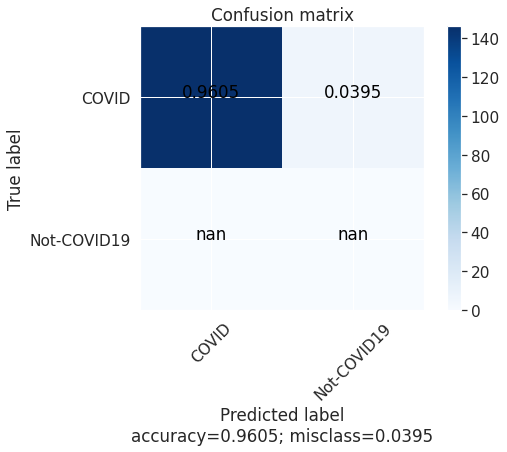

In [155]:
plot_confusion_matrix(mat,["COVID","Not-COVID19"])

Saving 01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg to 01E392EE-69F9-4E33-BFCE-E5C968654078 (1).jpeg
Saving 1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg to 1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D (1).jpeg
Saving 1-s2.0-S0140673620303706-fx1_lrg.jpg to 1-s2.0-S0140673620303706-fx1_lrg (1).jpg
Saving 1-s2.0-S0929664620300449-gr2_lrg-a.jpg to 1-s2.0-S0929664620300449-gr2_lrg-a (1).jpg
Saving 1-s2.0-S0929664620300449-gr2_lrg-b.jpg to 1-s2.0-S0929664620300449-gr2_lrg-b (1).jpg
Saving 1-s2.0-S0929664620300449-gr2_lrg-c.jpg to 1-s2.0-S0929664620300449-gr2_lrg-c (1).jpg
Saving 1-s2.0-S0929664620300449-gr2_lrg-d.jpg to 1-s2.0-S0929664620300449-gr2_lrg-d (1).jpg
Saving 1-s2.0-S0929664620300449-gr3_lrg-a.jpg to 1-s2.0-S0929664620300449-gr3_lrg-a.jpg
[-22.486187]
01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg is a covid +
[-17.49176]
1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg is a covid +
[-4.162984]
1-s2.0-S0140673620303706-fx1_lrg.jpg is a covid +
[-15.727911]
1-s2.0-S0929664620300449-gr2_lrg-a.jpg is a covid 

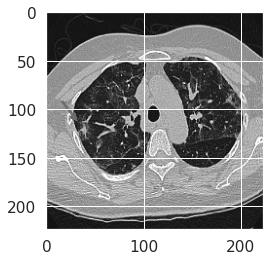

In [157]:
from keras.preprocessing import image
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224,224))
  plt.imshow(img)
  x = image.img_to_array(img)
  
  x = np.expand_dims(x, axis=0)/255.0

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<=0.5:
    print(fn + " is a covid +")
  else:
    print(fn + " is a covid -")

In [0]:
from google.colab import files
files.download('COVID-19(MobileNetv2).csv')